# Brain MRI Tumor Segmentation  
## Otsu vs Sauvola Thresholding

### Objective
To segment tumor regions in brain MRI images using:
- Global Otsu Thresholding
- Adaptive Sauvola Thresholding

### Evaluation Metrics
- Dice Coefficient
- Jaccard Index

### Dataset
Kaggle – Brain MRI Tumor Segmentation Dataset


In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_sauvola
from skimage.morphology import remove_small_objects

In [13]:
image_dir = "dataset/images"
mask_dir = "dataset/masks"

Image Loader

In [40]:
def load_data(filename):
    img_path = os.path.join(image_dir, filename)
    mask_path = os.path.join(mask_dir, filename)

    if not os.path.exists(mask_path):
        return None, None

    img = cv2.imread(img_path, 0)
    mask = cv2.imread(mask_path, 0)

    img = cv2.resize(img, (256,256))
    mask = cv2.resize(mask, (256,256))

    mask = mask > 127

    return img, mask

In [42]:
# remove background using Otsu
t = threshold_otsu(img)
brain = img > t

# apply mask to keep only brain area
brain_only = img * brain

# detect dark tumor region
tumor_otsu = brain_only < np.percentile(brain_only[brain_only>0], 40)

# remove noise
tumor_otsu = remove_small_objects(tumor_otsu, min_size=80)

In [43]:
s_thresh = threshold_sauvola(img, window_size=25)

brain = img > threshold_otsu(img)
brain_only = img * brain

tumor_sauvola = brain_only < (s_thresh * 0.9)

tumor_sauvola = remove_small_objects(tumor_sauvola, min_size=80)

In [44]:
otsu_mask = tumor_otsu.astype(bool)
sauvola_mask = tumor_sauvola.astype(bool)

In [46]:

def dice_score(pred, true):
    intersection = np.logical_and(pred, true).sum()
    return 2 * intersection / (pred.sum() + true.sum() + 1e-6)

def jaccard(pred, true):
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    return intersection / (union + 1e-6)

dice_otsu = dice_score(otsu_mask, true_mask)
dice_sauvola = dice_score(sauvola_mask, true_mask)

iou_otsu = jaccard(otsu_mask, true_mask)
iou_sauvola = jaccard(sauvola_mask, true_mask)

dice_otsu, dice_sauvola, iou_otsu, iou_sauvola  

(np.float64(0.0028568248431926533),
 np.float64(0.0016468775732024629),
 np.float64(0.001430455702290021),
 np.float64(0.0008241173968304945))

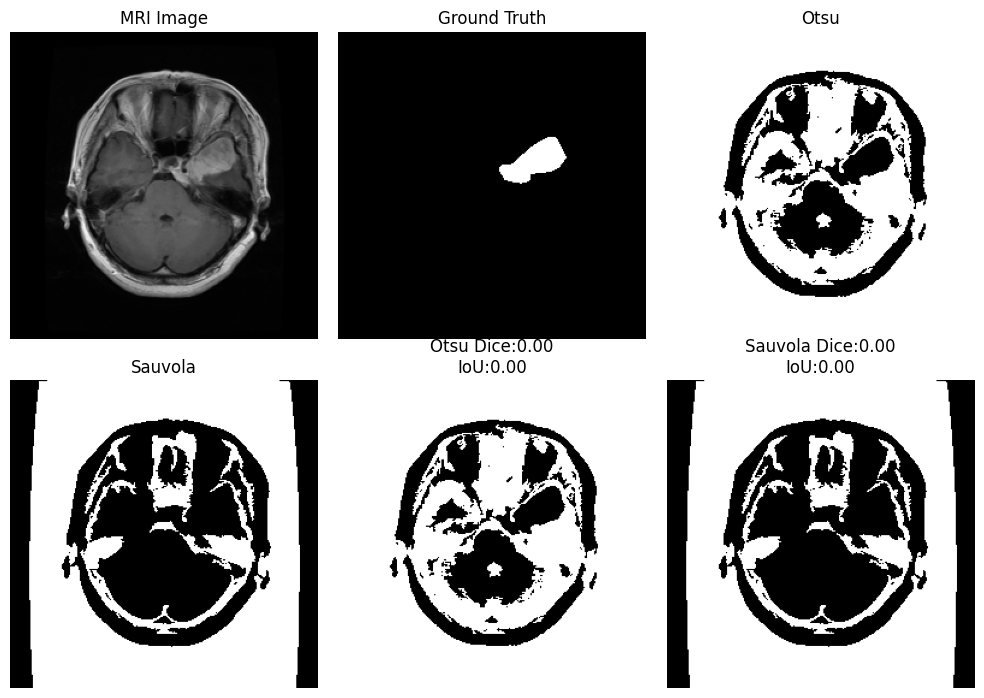

In [38]:
plt.figure(figsize=(10,7))

plt.subplot(2,3,1)
plt.title("MRI Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.title("Ground Truth")
plt.imshow(true_mask, cmap='gray')
plt.axis('off')

plt.subplot(2,3,3)
plt.title("Otsu")
plt.imshow(otsu_mask, cmap='gray')
plt.axis('off')

plt.subplot(2,3,4)
plt.title("Sauvola")
plt.imshow(sauvola_mask, cmap='gray')
plt.axis('off')

plt.subplot(2,3,5)
plt.title(f"Otsu Dice:{dice_otsu:.2f}\nIoU:{iou_otsu:.2f}")
plt.imshow(otsu_mask, cmap='gray')
plt.axis('off')

plt.subplot(2,3,6)
plt.title(f"Sauvola Dice:{dice_sauvola:.2f}\nIoU:{iou_sauvola:.2f}")
plt.imshow(sauvola_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [47]:
dice_o, dice_s = [], []
iou_o, iou_s = [], []

files = sorted(os.listdir(image_dir))

for file in files:
    img, true_mask = load_data(file)

    if img is None:
        continue

    t = threshold_otsu(img)
    otsu_mask = img < t

    s_thresh = threshold_sauvola(img, window_size=25)
    sauvola_mask = img < s_thresh

    otsu_mask = remove_small_objects(otsu_mask, 80)
    sauvola_mask = remove_small_objects(sauvola_mask, 80)

    dice_o.append(dice_score(otsu_mask, true_mask))
    dice_s.append(dice_score(sauvola_mask, true_mask))

    iou_o.append(jaccard(otsu_mask, true_mask))
    iou_s.append(jaccard(sauvola_mask, true_mask))

print("Average Dice (Otsu):", round(np.mean(dice_o),3))
print("Average Dice (Sauvola):", round(np.mean(dice_s),3))

Average Dice (Otsu): 0.003
Average Dice (Sauvola): 0.015


Conclusion : Failing to improve the iou and dice score